# Overview

In this tutorial we will introduce key concepts related to creating simple neural networks including a linear (single-layer) classifier as well as a multilayer perceptron.

**Linear Classifiers and Multilayer Perceptrons**

* matrix multiplication
* softmax cross-entroy loss
* model training
* evaluation
* visualization

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [ ]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 81 kB 3.5 MB/s 
     |████████████████████████████████| 596 kB 17.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries:

In [ ]:
import numpy as np, pandas as pd
from tensorflow import losses, optimizers
from tensorflow.keras import Input, Model, models, layers
from jarvis.train import datasets
from jarvis.utils.display import imshow

# Data

The data used in this tutorial will consist of the MNIST handwritten digit dataset. The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/mnist`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [ ]:
# --- Download dataset
datasets.download(name='mnist')

[ 2021-12-23 06:10:41 ] [====================] 100.000% : Extracting archive (0000004 / 0000004) 

{'code': '/data/raw/mnist', 'data': '/data/raw/mnist'}

Once downloaded, the `datasets.prepare(...)` method can be used to generate the required python Generators to iterate through the dataset, as well as a `client` object for any needed advanced functionality.

In [ ]:
# --- Prepare generators
gen_train, _, client = datasets.prepare(name='mnist')

[ 2021-12-23 06:10:51 ] [====================] 100.000% : Iterating | 000001    

By default the generator yields a batch size of 128 different images. As before, each iteration yields two variables, `xs` and `ys`, each representing a dictionary of model input(s) and output(s). In the current example, there is just a single input and output. Let us examine the generator data:

In [ ]:
# --- Yield one example
xs, ys = next(gen_train)

# --- Print dict keys
print('xs keys: {}'.format(xs.keys()))
print('ys keys: {}'.format(ys.keys()))

xs keys: dict_keys(['dat'])
ys keys: dict_keys(['digit'])


In [ ]:
# --- Print data shape
print('xs shape: {}'.format(xs['dat'].shape))
print('ys shape: {}'.format(ys['digit'].shape))

xs shape: (128, 784)
ys shape: (128, 1)


Each 28 x 28 2D image is serialized as a 784-element vector. Use the following lines of code to reshape the data vector and visualize using the `imshow(...)` method:

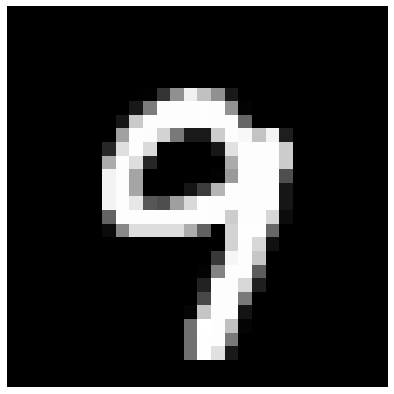

In [ ]:
# --- Reshape to 2D images
dat = xs['dat'].reshape(-1, 28, 28)

# --- Show the first example
imshow(dat[0])

Pass the entire dat array to `imshow(...)` to display an N x N mosaic of all images:

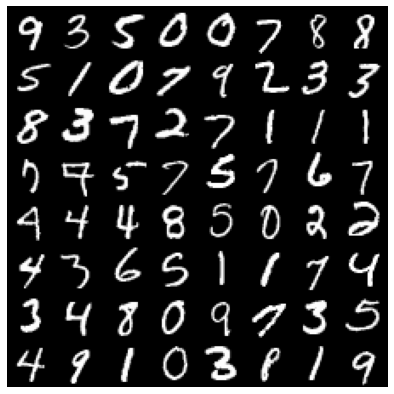

In [ ]:
# --- Show "montage" of first 64 images
imshow(dat[:64])

As expected, the 64-element `ys['digit']` vector corresponds to ground-truth:

In [ ]:
# --- Print ys['digit']
print(ys['digit'][:64].reshape(8, 8))

[[9 3 5 0 0 7 8 8]
 [5 1 0 7 9 2 3 3]
 [8 3 7 2 7 1 1 1]
 [7 7 5 7 5 7 6 7]
 [4 4 4 8 5 0 2 2]
 [4 3 6 5 1 1 7 4]
 [3 4 8 0 9 7 3 5]
 [4 9 1 0 3 8 1 9]]


# Foundations

As a review, recall the diagramatic representation of a neural network covered in lecture:

![Diagramtric Representation](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2020/notebooks/mlp/pngs/nn_diagram.png)

Recall that each reach "retinal neuron" recieving light from the image is connected to one of ten output neurons, each indicating the relative likelihood of that image representing any one of the ten possible digits. The neuron with the largest score value (e.g. **logit score**) in turn represents the most probable interpretation by the network of the provided digit image.

Also, recall that each connection itself is modeled by a multiplicative weight value that represents how strong (or weak) the connection is, and that each of the 784 connections to one of our ten output neurons can in fact be represented as a matrix of numbers:

![Matrix Representation](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2020/notebooks/mlp/pngs/nn_multiply.png)

Of course, for each of our ten digits, we will have a different 28 x 28 weight matrix for a total of 10 weight matrices. Finally keep in mind that for the sake of ease in representation (given our simple model) both our 28 x 28 input matrix and ten 28 x 28 weight matrices can be **flattened** to just a single 1 x 784 (or 784 x 1) matrix. 

# Matrix Multiplication

### Input

As in the earlier examples, the first dimension of the input matrix `x` will be `None` to indicate that one or many images can be passed through the model at a time. The second dimension of the input matrix will need to accomodate a **flattened** version of our 28 x 28 matrix:

```
x = [[x00, x01, x02, ...],   ==> (flattening) ==> [[x00, x01, x02, x10, x11, ..., xNN]]
     [x10, x11, x12, ...],
     [x20, x21, x22, ...]
     ... , ..., ..., xNN]]
```

Thus our input matrix will need to be `(None, 28 x 28)` = `(None, 784)`. Use the following code cell to create our `Input(...)` object:

In [ ]:
# --- Create Tensorflow input
x = Input(shape=(784,))
print(x.shape)

(None, 784)


Recall that the data generator above yields a dictionary of possible `xs` inputs. To accomodate for this potential of multi-input models, the Tensorflow 2.0 / Keras simply specifies that each defined `Input()` object be maintained in a dictionary with matching keys and names:

In [ ]:
# --- Create Tensorflow input dict
inputs = {}
inputs['dat'] = Input(shape=(784,), name='dat')

### client.get_inputs(...)

Alternatively, instead of manually creating each potential model input, the `client` object as part of the Jarvis library has a convenience method to automatically create matching input(s) for all the input arrays yielded as part of `xs`. To use, simply pass the Tensorflow `Input` class to the `client.get_inputs(...)` method:

In [ ]:
# --- Create model inputs
inputs = client.get_inputs(Input)

print(inputs.keys())
print(inputs['dat'].shape)

dict_keys(['dat'])
(None, 784)


In [ ]:
inputs

{'dat': <KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'dat')>}

### Dense operation

The next step is to define the proper matrix multiplication operation to implement mapping of input (image) to output (digit logit scores). Recall the earlier discussion on **dense** layers and matrix multiplication:

```
Let:

X = 1 x N matrix = [a, b, c, d, e...]

M = N x 1 matrix = [[A],
                    [B],
                    [C],
                    [D],
                    [E],
                    ...
                    ]

Then:

X x M = ...

= [[a, b, c, d, e...]] x [[A], = a * A + b * B + c * C + d * D + e * E ...
                          [B],
                          [C],
                          [D],
                          [E],
                          ...
                          ]
                          
```

The following rules extend this formally to 2D matrices.

```
Let:

X = I x N matrix
M = N x J matrix
```

1. The **second** dimension of `X` must match the **first** dimension of `M` (e.g. `N`).
2. The output of the matrix multiplication is equal to the **first** dimension of `X` by the **second** dimension of `Y` (e.g. `I x J`).

Given the discussion above, in order to define a *matrix multiplication* between the input Tensor and the `m` weights matrix, what shape must the `m` weights matrix consist of to yield 10 different logit score predictions?

Use the following code cell to create the appropriate operation object:

In [ ]:
# --- Create op
op = layers.Dense(10) #of elements on output side

# --- Create output
y = op(inputs['dat'])
print(y.shape)

(None, 10)


Let us check to see if the weights are of correct shape:

In [ ]:
# --- Get weight matrix shape
w, b = op.get_weights()
print(w.shape)

(784, 10)


### Output

Just as the Generator input `xs` is defined as a dictionary of one or multiple model inputs, the Generator output `ys` is defined as a dictionary of one or multiple model outputs. To accomodate for this, the Tensorflow 2.0 / Keras API simply specifies that each output logit score (defined via a `Tensor` object) is maintained in a dictionary. Just like inputs, the logit score object(s) must also have matching names where are defined in the **final operation** that yields the logit score `Tensor` object: 

In [ ]:
# --- Create op (note that the output Tensor name must also be defined here)
op = layers.Dense(10, name='digit')

# --- Create outputs
logits = {}
logits['digit'] = op(inputs['dat'])

### Creating the model

This single operation model successfully defines the linear classification model as presented during lecture. Use the following line of code to create the model:

In [ ]:
# --- Create model
model = Model(inputs=inputs, outputs=logits)

Use the following line of code to pass a single batch of data through the created model:

In [ ]:
# --- Predict
scores = model.predict(xs['dat'])

In [ ]:
xs['dat'].shape

(128, 784)

In [ ]:
type(xs['dat'])

numpy.ndarray

In [ ]:
scores.keys()

dict_keys(['digit'])

What is the output shape of the `scores` variable, what does this variable represent?

In [ ]:
# --- Logit scores
print(scores['digit'].shape)

(128, 10)


In [ ]:
scores['digit'][0] #logit score for first input

array([ 0.91842407,  2.333152  , -0.37827992, -1.5631016 , -4.8034024 ,
        2.9353895 , -0.2195639 , -2.6826556 , -0.40502238,  1.8952456 ],
      dtype=float32)

In [ ]:
np.argmax(scores['digit'][0]) #prediction for first input

5

In [ ]:
np.argmax(scores['digit'], axis = -1) #prediction for all inputs 

array([5, 9, 0, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 8, 0, 5, 1,
       2, 1, 5, 9, 1, 1, 1, 1, 0, 5, 1, 9, 9, 0, 9, 0, 0, 9, 1, 9, 2, 2,
       1, 1, 1, 9, 1, 9, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 9, 0, 1, 1, 1, 5,
       1, 1, 1, 5, 1, 1, 1, 5, 3, 8, 8, 1, 9, 9, 1, 1, 1, 3, 8, 5, 5, 0,
       0, 9, 0, 5, 5, 1, 9, 1, 1, 1, 3, 1, 1, 9, 9, 1, 9, 1, 0, 0, 0, 1,
       1, 1, 1, 5, 9, 0, 5, 1, 1, 5, 3, 1, 0, 0, 0, 0, 1, 1])

# Compiling the Model

### Softmax cross-entropy loss

After generating **logit** scores, one must define a method to: (1) convert logit scores to final prediction; (2) quantify the *goodness* of model prediction. These steps are performed mathematically with what is known as a loss function. For classification problems, the standard function to use is the **softmax cross-entropy** loss. This loss in fact is composed of two seperate steps:

* **softmax**: method to normalize logit scores into a probability distribution
* **cross-entropy**: method to quantify difference between predicted distribution and true distribution

To define a softmax cross-entropy loss in Tensorflow, use the `losses.SparseCategoricalCrossentropy(...)` class. The sparse formulation is a special case of cross-entropy loss where only a single mutually exclusive class is correct for any given input. The `from_logits=True` argument is used to denote that raw logit scores are passed as input and that a softmax normalization is required before calculating cross-entropy loss. It is recommended to perform these two steps simultaneously rather than split into two seperate operations for numeric stability.

In [ ]:
# --- Define a loss object
sce = losses.SparseCategoricalCrossentropy(from_logits=True) #from_logit will do softmax and cross-entropy

For demonstration, use the following lines of code to calculate the loss for the generate logit scores of the current data batch:

In [ ]:
# --- Calculate loss
sce(y_true=ys['digit'], y_pred=scores['digit'])

<tf.Tensor: shape=(), dtype=float32, numpy=3.885454>

As training proceeds, the goal of the algorithm is to update weights in a manner such that this loss value decreases over time.

### Adam optimizer

In [ ]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=1e-2)

# Summary

Putting everything together, use the following cell to define, create and compile the single-layer linear classifier model for the MNIST dataset:

In [ ]:
# --- Create model inputs
inputs = client.get_inputs(Input)

# --- Define model
logits = {}
logits['digit'] = layers.Dense(10, name='digit')(inputs['dat']) #creates operation and pass inputs into created operation layer and gets ouput in one line of code

# --- Create model
model = Model(inputs=inputs, outputs=logits)

# --- Compile model
model.compile(
    optimizer=optimizer,
    loss={'digit': sce},
    metrics={'digit': 'sparse_categorical_accuracy'}) #metrics recapitulates the loss and shows how good the model is by showing a percent accuracy

Note that given the dictionary of potential output(s), each of which may have it's own separate loss function and/or accuracy metric:

* loss must represent a dictionary of loss objects with keys matching `ys`
* metrics must represent a dictionary of metrics with keys matching `ys`

# Model Training

Once the model has been compiled and the data prepared (via a generator), training can be invoked using the `model.fit(...)` method. The only parameters that need to be set relate to the number of total training iterations (total number of steps = `steps_per_epoch` x `epochs`). 

In [ ]:
model.fit(
    x=gen_train, 
    steps_per_epoch=250, 
    epochs=4)

Epoch 1/4
250/250 [==============================] - 23s 91ms/step - loss: 1.0582 - sparse_categorical_accuracy: 0.8193
Epoch 2/4
250/250 [==============================] - 23s 90ms/step - loss: 0.5203 - sparse_categorical_accuracy: 0.8745
Epoch 3/4
250/250 [==============================] - 23s 92ms/step - loss: 0.5378 - sparse_categorical_accuracy: 0.8776
Epoch 4/4
250/250 [==============================] - 23s 90ms/step - loss: 0.6008 - sparse_categorical_accuracy: 0.8734


### Evaluation

To test the trained model, the following steps are required:

* load data
* use `model.predict(...)` to obtain logit scores
* use `np.argmax(...)` to obtain prediction
* compare prediction with ground-truth
* serialize in Pandas DataFrame

Recall that the generator used to train the model simply iterates through the dataset randomly. For model evaluation, the cohort must instead be loaded manually in an orderly way. For this tutorial, use the `client.get(rows=...)` method. Since there is no special train or valid split currently, simply load all 60,000 examples:

In [ ]:
# --- Load all data
arrs = client.get(rows=np.arange(60000))

Use the following lines of code to run prediction:

In [ ]:
# --- Predict
scores = model.predict(arrs['xs']['dat'])

# --- Argmax
pred = np.argmax(scores['digit'], axis=1)

In [ ]:
pred.size

60000

In [ ]:
pred #all the predictions 

array([5, 0, 4, ..., 5, 6, 9])

In [ ]:
arrs['ys'].keys()

dict_keys(['digit'])

In [ ]:
arrs['ys']['digit'].shape

(60000, 1)

Prepare results in Pandas DataFrame for ease of analysis and sharing:

In [ ]:
df = pd.DataFrame(index=np.arange(60000))

# --- Define columns
df['true'] = arrs['ys']['digit'][:, 0]
df['pred'] = pred
df['corr'] = df['true'] == df['pred']

# --- Print accuracy
print(df['corr'].mean())

0.8886833333333334


In [ ]:
df['corr']

0         True
1         True
2         True
3         True
4         True
         ...  
59995     True
59996     True
59997     True
59998     True
59999    False
Name: corr, Length: 60000, dtype: bool

In [ ]:
df['corr'].mean()

0.8886833333333334

# Visualization

What are the expected weights learned by the model? Use the following lines of code to visualize:

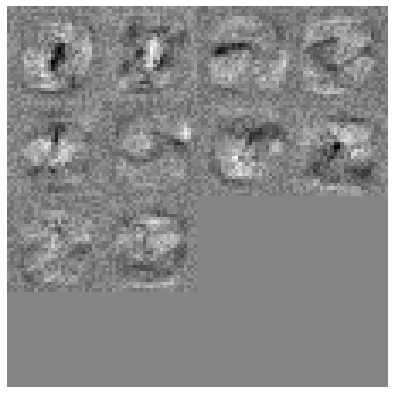

In [ ]:
# --- Get weights of first layer
weights = model.layers[1].get_weights()[0]

# --- Show
imshow(weights.T.reshape(-1, 28, 28))

## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `model.save()` and `models.load_model()` methods. 

In [ ]:
# --- Serialize a model
model.save('./mlp.hdf5')

In [ ]:
# --- Load a serialized model
del model
model = models.load_model('./mlp.hdf5', compile=False)

# Exercises

The following exercise questions will assist in preparation for this lesson's assignment, to extend our single-layer linear classifier into a multilayer perceptron.

### Exercise 1

The key to synthesizing multiple layers is the addition of activation functions after each matrix multiplication. How do you add a **relu** activation to the `layers.Dense(...)` call? 

Use the following cell to experiment:

In [ ]:
logits = layers.Dense(10, activation = 'relu', name='digit')(inputs['dat'])

#### Hints

Use the Jupyter / iPython `?` command to see function and class initialization signatures:

In [ ]:
layers.Dense?

### Exercise 2

All hidden layers require an activation function, however the last layer (e.g. the layer that yields the final logit scores) **does not**. Why is this so?

Create a single hidden layer neural network below, ensuring that the last layer does not have any activation function:

In [ ]:
# --- Define hidden layer size
#hidden_size = 

# --- Define network
hidden = layers.Dense(350, activation='relu')(inputs['dat'])
logits = layers.Dense(10, name='digit')(hidden) 

#### Hints

If defined correctly, the model **logit scores** should return values that are both negative and positive. If the `ReLU` activation was accidently applied to the last layer, the logit scores should only be positive. How do we check for this?

In [ ]:
# --- Create the model
model = Model(inputs=inputs, outputs=logits)

In [ ]:
w, b = op.get_weights()
w.shape

(784, 10)

In [ ]:
b.shape

(10,)

In [ ]:
# --- Pass an example xs input into the model
xs, ys = next(gen_train)
scores = model.predict(arrs['xs']['dat'])
scores = model.predict(xs['dat'])

# --- Print scores
print(scores)

[[ 4.22514153e+00 -1.44488657e+00  1.87238407e+00 ... -2.46186543e+00
  -2.15022087e+00  2.08985901e+00]
 [ 2.25170135e+00 -1.89384604e+00 -8.49907100e-01 ... -9.48669910e-01
  -4.14025784e-03  1.69385147e+00]
 [ 6.82925224e-01  6.13607287e-01  6.32457376e-01 ... -1.19430125e+00
   4.89405036e-01  7.06534266e-01]
 ...
 [ 5.85571766e+00 -1.04787147e+00  3.96458387e-01 ...  2.91894007e+00
   1.00359023e-01  3.18632412e+00]
 [ 9.04066563e-01 -2.82225192e-01 -3.96924496e-01 ... -4.36955571e-01
   1.33879185e-02  1.38364398e+00]
 [ 3.32911062e+00 -2.64329791e-01 -1.85595131e+00 ...  4.46972370e-01
  -6.32117391e-01 -7.76379347e-01]]
